In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import pickle

import pandas as pd
import numpy as np

import hyperopt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, auc 

from sklearn.linear_model import LogisticRegression

from catboost import Pool, CatBoostClassifier

import TrainLog, TrainCat

In [2]:
SEED = 12

# ✅Полный цикл!

В этом ноутбуке мы проделаем полный путь создания МЛ моделей - от обработки данных, создания базовых моделей и тьюнинга моделей по максимуму. Подробнее, зачем это нужно, смотрим <a href='https://habr.com/ru/companies/raft/articles/785616/'>здесь</a>.

Начнем с ставшей уже стандартной для нас обработки данных!

In [3]:
dataset = pd.read_csv('Titanic-Dataset.csv')
dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
dataset.fillna(-1, inplace=True)

dataset_coded = dataset.copy()

dataset_coded['Sex'] = np.where(dataset_coded['Sex'] == 'male', 1, 0)

cat_features = dataset_coded.drop(['Sex'], axis=1).select_dtypes(include=['object'])
cat_columns = list(cat_features.columns)
dataset_coded.drop(cat_columns, axis=1, inplace=True)
cat_features.replace(-1, '-1', inplace=True)

ohe = OneHotEncoder()
ohe.fit(cat_features)
coded_cat_features = pd.DataFrame(ohe.transform(cat_features).toarray(), columns=ohe.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, coded_cat_features], axis=1)

standard_scaler = StandardScaler()
standard_scaler.fit(dataset_coded.drop(['Survived'], axis=1))
dataset_coded = pd.DataFrame(standard_scaler.transform(dataset_coded.drop(['Survived'], axis=1)), columns=standard_scaler.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, dataset['Survived']], axis=1)

In [4]:
target = dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(dataset_coded.drop(['Survived'], axis=1), target, test_size=0.3, random_state=12)
# нужно для Catboost-а
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# ✅Построим baseline модели!

In [5]:
logreg_baseline = LogisticRegression()
logreg_baseline.fit(X_train, y_train)
lorger_train = roc_auc_score(y_train, logreg_baseline.predict(X_train))
logreg_test = roc_auc_score(y_test, logreg_baseline.predict(X_test))

boost_baseline = CatBoostClassifier(verbose=False)
boost_baseline.fit(train_pool)
boost_train = roc_auc_score(y_train, boost_baseline.predict(train_pool))
boost_test = roc_auc_score(y_test, boost_baseline.predict(test_pool))

baseline_res = pd.DataFrame(
    [
        [lorger_train, logreg_test],
        [boost_train, boost_test]
    ],
    columns=['Train', 'Test'],
    index=['LogReg Baseline', 'Boost Baseline']
)

baseline_res

,Train,Test
LogReg Baseline,0.778899,0.754136
Boost Baseline,0.899879,0.749405


# ✅Улучшим!

При помощи наших разработанных конвейеров улучшим метрики baseline моделей и попытаемся снизить эффект переобучения!

100%|████████| 10/10 [00:00<00:00, 24.45trial/s, best loss: -0.8457723127935894]


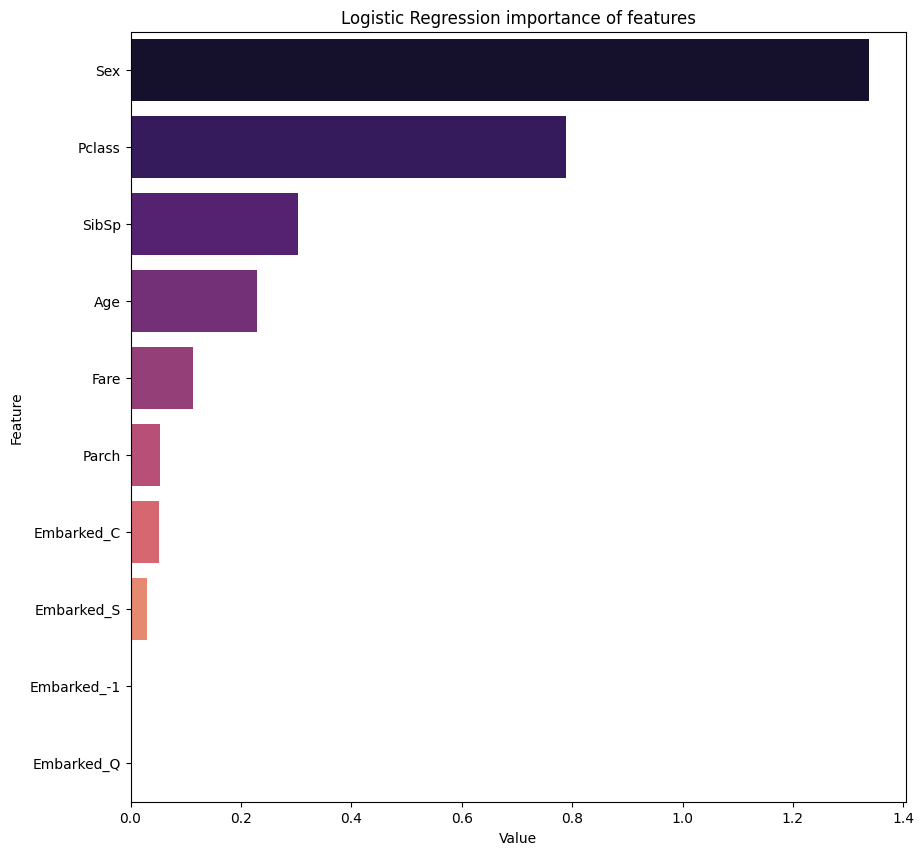

In [6]:
custom_logreg_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': (0.001, 10),
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': (100, 1000),
    'l1_ratio': (0, 1),
}

logistic_regression = TrainLog.TrainLogisticRegressionModel(
    x_train=X_train, y_train=y_train,
    x_test=X_test, y_test=y_test,
    random_seed=SEED,
    params_dict=custom_logreg_params
)

best_logreg, cv_score_logreg, test_score_logreg = logistic_regression.train()

100%|████████| 10/10 [00:03<00:00,  2.96trial/s, best loss: -0.8540268242395902]


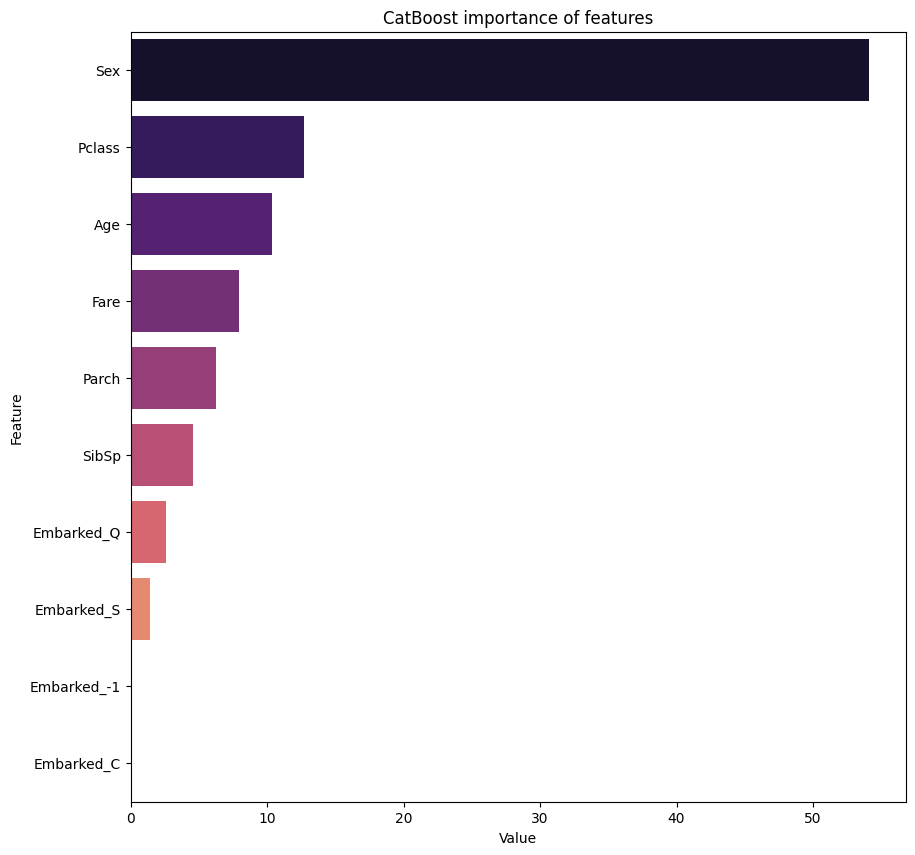

In [7]:
custom_catboost_params = {
    'boosting_type':  ['Ordered', 'Plain'],
    'iterations': (100, 150),
    'learning_rate': (0.01, 0.9),
    'depth': (1, 2, 1),
    'l2_leaf_reg': (1e-8, 10),
    'min_data_in_leaf': (30, 250, 10)
}

boosting = TrainCat.TrainCatBoostModel(
    x_train=X_train, y_train=y_train,
    x_test=X_test, y_test=y_test,
    random_seed=SEED,
    params_dict=custom_catboost_params
)

best_boosting, cv_score_boosting, test_score_boosting = boosting.train()

А теперь посмотрим на результат.

In [8]:
tuned_res = pd.DataFrame(
    [
        [cv_score_logreg, test_score_logreg],
        [cv_score_boosting, test_score_boosting]
    ],
    columns=['Cross-Val', 'Test'],
    index=['LogReg Tuned', 'Boost Tuned']
)

tuned_res

,Cross-Val,Test
LogReg Tuned,0.845772,0.829105
Boost Tuned,0.854027,0.852383


Посмотрим также и на ROC-кривые

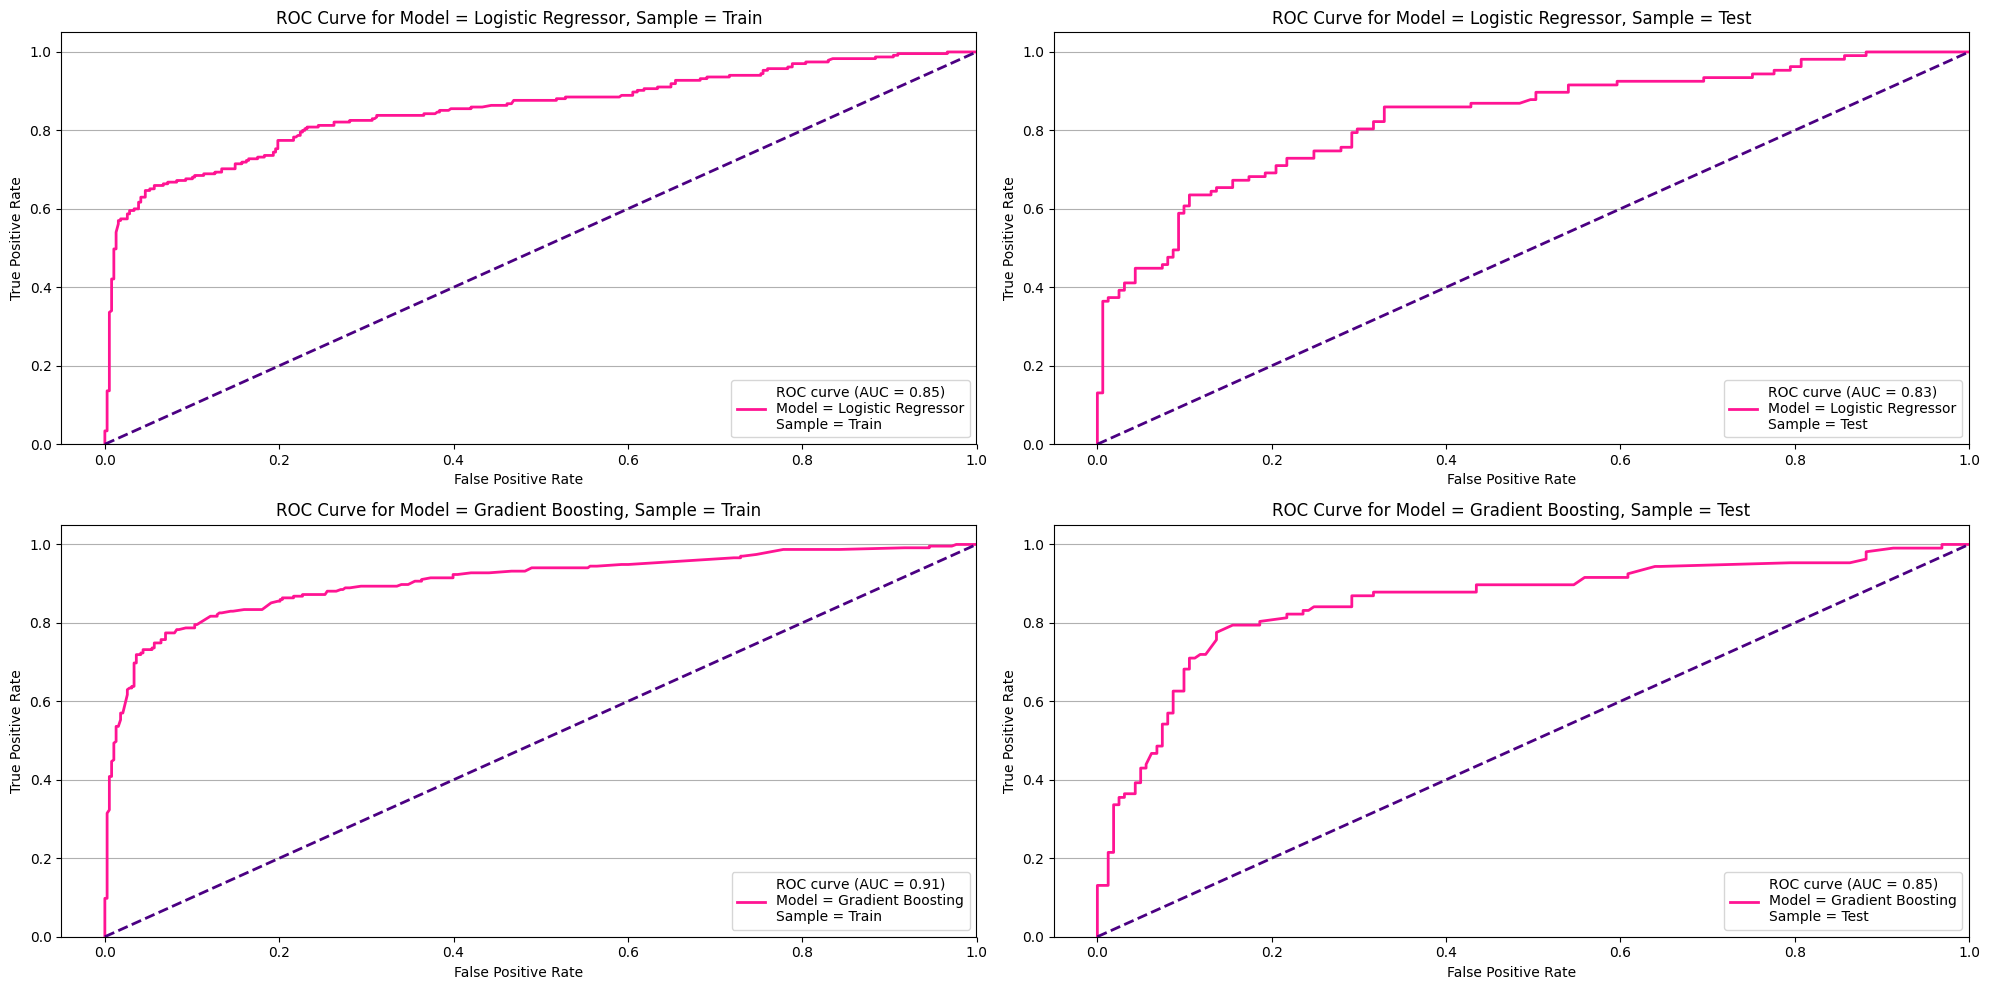

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()  # преобразуем в плоский массив для удобства

models = [
    (best_logreg, 'TRAIN', (X_train, y_train), ('Logistic Regressor', 'Train')),
    (best_logreg, 'TEST', (X_test, y_test), ('Logistic Regressor', 'Test')),
    (best_boosting, 'TRAIN', (train_pool, y_train), ('Gradient Boosting', 'Train')),
    (best_boosting, 'TEST', (test_pool, y_test), ('Gradient Boosting', 'Test')),
]

for model, ax_i in zip(models, ax):
    
    y_score = model[0].predict_proba(model[2][0])[:, 1]
    
    fpr, tpr, _ = roc_curve(model[2][1], y_score)
    roc_auc = auc(fpr, tpr)
    
    ax_i.plot(fpr, tpr, color='deeppink', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})\nModel = {model[3][0]}\nSample = {model[3][1]}')
    
    ax_i.plot([0, 1], [0, 1], color='indigo', lw=2, linestyle='--')
    ax_i.set_xlim([-0.05, 1.0])
    ax_i.set_ylim([0.0, 1.05])
    ax_i.set_xlabel('False Positive Rate')
    ax_i.set_ylabel('True Positive Rate')
    ax_i.set_title(f'ROC Curve for Model = {model[3][0]}, Sample = {model[3][1]}')
    ax_i.legend(loc='lower right')
    ax_i.grid(True, axis='y')

plt.tight_layout()
plt.show()

# ✅ Отберем признаки!

Для чего? - отбор "самых важных" признаков производится с целью облегчения модели, дабы в дальейшем ее проще было использовать. Попробуем при помощи прямого и обратного прохода отобрать самые важные признаки!

In [10]:
bs_logistic = TrainLog.FeatureSelectorLR(
    x_train=X_train, y_train=y_train,
    x_test=X_test, y_test=y_test,
    random_state=SEED,
    scale_data=False # Мы уже скалировали данные
)

short_logistic, rest = bs_logistic.backward_selector()

0.75 0.95 0.75 0.95 -inf -inf
Columns remaining 8
Starting feature stability testing


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 360.44it/s]

0 potential columns to drop


In [11]:
short_logistic

['Sex', 'Pclass', 'SibSp', 'Age', 'Fare', 'Embarked_C', 'Parch', 'Embarked_S']

In [12]:
logreg_params = best_logreg.get_params()
del logreg_params['random_state']

bs_logistic.x_train = X_train[short_logistic]
bs_logistic.x_test = X_test[short_logistic]

bs_logistic.forward_selector(
    target='Survived',
    params=logreg_params,
    n_stop=30
)

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 19.54it/s]


,Feature name,AUC Train,AUC Val,Delta AUC Train,Delta AUC Val
0,SibSp,0.500534,0.556152,NaN,NaN
1,Fare,0.506619,0.602018,0.006085,0.045865
2,Embarked_S,0.530742,0.607190,0.024123,0.005172
3,Embarked_C,0.531265,0.608554,0.000523,0.001364
4,Sex,0.537590,0.597130,0.006324,-0.011424
5,Pclass,0.548453,0.574027,0.010863,-0.023103
6,Parch,0.555912,0.552259,0.007459,-0.021768
7,Age,0.566280,0.478573,0.010368,-0.073686


In [13]:
bs_boosting = TrainCat.FeatureSelector(
    x_train=X_train, y_train=y_train,
    x_test=X_test, y_test=y_test,
    random_state=SEED,
    cat_features=[]
)

short_boosting, rest = bs_boosting.backward_selector()

0.77 0.93 0.77 0.93 -inf -inf
Columns remaining 8
0.79 0.94 0.79 0.94 0.77 0.93
Columns remaining 6
0.78 0.95 0.78 0.95 0.79 0.94
Starting feature stability testing


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]

0 potential columns to drop


In [14]:
short_boosting

array(['Sex', 'Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'Embarked_S',
       'Embarked_C'], dtype='<U10')

In [15]:
boosting_params = best_boosting.get_params()
del boosting_params['random_seed']

bs_boosting.x_train = X_train[short_boosting]
bs_boosting.x_test = X_test[short_boosting]

bs_boosting.forward_selector(
    target='Survived',
    params=boosting_params,
    n_stop=30
)

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.61it/s]


,Feature name,AUC Train,AUC Val,Delta AUC Train,Delta AUC Val
0,Parch,0.545911,0.538079,NaN,NaN
1,Fare,0.774891,0.586076,0.228980,0.047997
2,SibSp,0.777895,0.555669,0.003004,-0.030406
3,Pclass,0.788035,0.556380,0.010140,0.000710
4,Embarked_C,0.787267,0.553623,-0.000768,-0.002756
5,Embarked_S,0.795794,0.549986,0.008527,-0.003637
6,Age,0.848246,0.519722,0.052452,-0.030264
7,Sex,0.861907,0.505485,0.013661,-0.014237


Из прямого отбора видно, что еще уменьшать шорты - не вариант.

# ✅Построим, обучим и сохраним облегченные модели

In [16]:
save_logreg = LogisticRegression(
    **best_logreg.get_params()
)

save_logreg.fit(pd.concat([X_train, X_test], axis=0)[short_logistic], pd.concat([y_train, y_test], axis=0))

with open(os.path.join(os.getcwd(), 'logreg_titanic.pkl'), 'wb') as f:
    pickle.dump(save_logreg, f)

In [17]:
save_boosting = CatBoostClassifier(
    **best_boosting.get_params(),
    verbose=False
)

save_boosting.fit(pd.concat([X_train, X_test], axis=0)[short_boosting], pd.concat([y_train, y_test], axis=0))

with open(os.path.join(os.getcwd(), 'boosting_titanic.pkl'), 'wb') as f:
    pickle.dump(save_boosting, f)